# Check alpha constraints for bispectrum

### Import all modules

In [1]:
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from itertools import permutations
from scipy.interpolate import RegularGridInterpolator as rgi
import scipy.interpolate as interpolate
import pandas as pd
import scipy.stats

## Load data

In [2]:
Bk=np.load("bk_z0.50.npz")

In [3]:
k=Bk['k']
br=Bk['bkr']
bkrm=Bk['bkrm'].T[0]

In [4]:
bkrm

array([1.23460239, 1.04134798, 0.99714893, ..., 1.00063003, 1.00521369,
       1.01014833])

## Interpolation

#### 1. scipy.interpolate.RegularGridInterpolator

In [5]:
k1=np.unique(k[:,0])
k2=np.unique(k[:,1])
k3=np.unique(k[:,2])

kk1,kk2,kk3=np.meshgrid(k1,k2,k3)

tup_Bk=[tuple(i) for i in k[:,0:3]]

In [6]:
output = np.empty(shape=(len(k1),len(k2),len(k3)))

for i in range(len(k1)):
    for j in range(len(k2)):
        for l in range(len(k3)):
            kkk=[i for i in permutations((kk1[i,j,l],kk2[i,j,l],kk3[i,j,l]))]
            if any(set(kkk).intersection(set(tup_Bk))):
                ind=tup_Bk.index(list(set(kkk).intersection(set(tup_Bk)))[0])
                output[i,j,l]=bkrm[ind]
            else:
                output[i,j,l]=np.nan                

In [7]:
print(output[:2,:2,:2])

[[[1.23460239        nan]
  [       nan 1.04134798]]

 [[       nan 1.04134798]
  [1.04134798 0.90469183]]]


#### Interpolating the above 3d matrix(output) in itself so that the nan values (at positions where bk doesn't exist) gets filled. This is done only for the 3d interpolation purpose. The k-values at those positions won't be considered later anyway. 

In [8]:
output_fillnan=output.flatten()
output_fillnan=pd.DataFrame(output_fillnan)
output_fillnan=output_fillnan.interpolate(method='linear', limit_direction='forward', axis=0)

In [9]:
output_fillnan=np.array(output_fillnan)
output_fillnan=np.reshape(output_fillnan,(len(k1),len(k2),len(k3)))

In [10]:
output_fillnan[:2,:2,:2]

array([[[1.23460239, 1.22836838],
        [1.04758199, 1.04134798]],

       [[1.01866094, 1.04134798],
        [1.04134798, 0.90469183]]])

In [11]:
ffb=rgi((k1,k2,k3),output_fillnan,method="linear",bounds_error=False,fill_value=None)
#plt.plot(ff((kg[:,0],kg[:,1],kg[:,2])))
#plt.plot(bg)

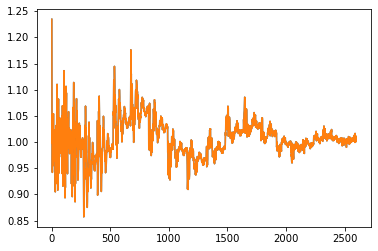

In [12]:
plt.plot(ffb((k)))
plt.plot(bkrm)

### Masking/Slicing

In [23]:
def cutslice(kmin,kmax):
    is_good = np.ones(k.shape[0], '?')
    for i in range(3):is_good &= (k[:, i] > kmin) & (k[:, i] < kmax)
    kg = k[is_good, :]
    bg = bkrm[is_good]
    nbins, nmocks = br[is_good, :].shape
    hartlapf = (nmocks-1.0)/(nmocks-nbins-2.0)
    print(f'kmax={kmax}, kmin={kmin}, nbins={nbins}, nmocks={nmocks}, hf = {hartlapf}')
    cov = np.cov(br[is_good, :], rowvar=True)/ nmocks
    icov = inv(cov)
    return kg,bg,cov,hartlapf

In [26]:
hf=[]
for j in reversed(k1[3:]):
    _,_,_,h=cutslice(0.005,j)
    hf.append(h)

kmax=0.295, kmin=0.005, nbins=2331, nmocks=922, hf = -0.6527285613040397
kmax=0.285, kmin=0.005, nbins=2107, nmocks=922, hf = -0.7759056444818871
kmax=0.275, kmin=0.005, nbins=1898, nmocks=922, hf = -0.941717791411043
kmax=0.265, kmin=0.005, nbins=1703, nmocks=922, hf = -1.1762452107279693
kmax=0.255, kmin=0.005, nbins=1522, nmocks=922, hf = -1.5299003322259137
kmax=0.245, kmin=0.005, nbins=1354, nmocks=922, hf = -2.122119815668203
kmax=0.235, kmin=0.005, nbins=1199, nmocks=922, hf = -3.3010752688172045
kmax=0.225, kmin=0.005, nbins=1056, nmocks=922, hf = -6.772058823529412
kmax=0.215, kmin=0.005, nbins=925, nmocks=922, hf = -184.2
kmax=0.205, kmin=0.005, nbins=805, nmocks=922, hf = 8.008695652173913
kmax=0.195, kmin=0.005, nbins=696, nmocks=922, hf = 4.111607142857143
kmax=0.185, kmin=0.005, nbins=597, nmocks=922, hf = 2.8513931888544892
kmax=0.175, kmin=0.005, nbins=508, nmocks=922, hf = 2.2354368932038833
kmax=0.165, kmin=0.005, nbins=428, nmocks=922, hf = 1.8719512195121952
kmax=0.

In [27]:
kg,bg,cov,_=cutslice(0.005,0.2)

kmax=0.2, kmin=0.005, nbins=805, nmocks=922, hf = 8.008695652173913


## Chi-square test

In [195]:
def chisq(obs, exp, cov):
    delta=np.abs(obs-exp)
    cov_inv=inv(cov)
    return delta.dot(cov_inv.dot(delta))

In [196]:
alp=np.linspace(0.999,1.001,100)
def chisq_alp(k,alp,cov):
    error=[]
    obs=ffb((k[:,0],k[:,1],k[:,2]))
    for i in alp:
        exp=ffb((k[:,0]*i,k[:,1]*i,k[:,2]*i))
        #print(round(i,10),"\t",chisq(obs, exp, cov))
        error.append((chisq(obs, exp, cov)))
    return error

In [197]:
error=chisq_alp(kg,alp,cov)

Text(0, 0.5, 'chi-square')

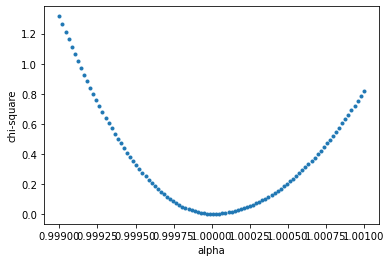

In [198]:
plt.plot(alp,error,".")
plt.xlabel("alpha")
plt.ylabel("chi-square")

### Plot chisq vs alpha for different kmax values

In [214]:
alp=np.linspace(0.85,1.15,1000)

kmin=0.005
kmax_min=0.045
kmax_max=0.2
all_errors=[]
all_kmax=[]
for kmax in reversed(np.unique(k[:,0])):
    if kmax>kmax_min and kmax<kmax_max:
        ki,bki,covi,_=cutslice(kmin,kmax)
        errori=chisq_alp(ki,alp,covi)
        all_errors.append(errori)
        all_kmax.append(kmax)
        print(kmax,np.min(errori))

kmax=0.195, kmin=0.005, nbins=696, nmocks=922, hf = 4.111607142857143
0.195 0.05893854141489595
kmax=0.185, kmin=0.005, nbins=597, nmocks=922, hf = 2.8513931888544892
0.185 0.03563290219857862
kmax=0.175, kmin=0.005, nbins=508, nmocks=922, hf = 2.2354368932038833
0.175 0.02096654875099906
kmax=0.165, kmin=0.005, nbins=428, nmocks=922, hf = 1.8719512195121952
0.165 0.014723235807241856
kmax=0.155, kmin=0.005, nbins=357, nmocks=922, hf = 1.6358792184724689
0.155 0.01049898748220927
kmax=0.145, kmin=0.005, nbins=294, nmocks=922, hf = 1.4712460063897763
0.145 0.005728530521821628
kmax=0.135, kmin=0.005, nbins=239, nmocks=922, hf = 1.3524229074889869
0.135 0.003324411785517933
kmax=0.125, kmin=0.005, nbins=191, nmocks=922, hf = 1.2633744855967077
0.125 0.002665241048121861
kmax=0.115, kmin=0.005, nbins=150, nmocks=922, hf = 1.1961038961038961
0.115 0.0016555950242025295
kmax=0.105, kmin=0.005, nbins=115, nmocks=922, hf = 1.1440993788819875
0.105 0.0008175007900505352
kmax=0.095, kmin=0.005,

Text(0.5, 0, 'alpha')

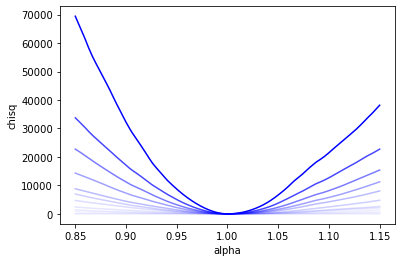

In [215]:
alpha = np.geomspace(1,0.01,len(all_errors))
for i,error in enumerate(all_errors):
    plt.plot(alp,error,alpha=alpha[i],color = 'b')
plt.ylabel("chisq")
plt.xlabel("alpha")
#plt.savefig("all_chisq.png")

### 1sigma constriant vs kmax

Find 1sigma confidence interval (of chisq vs alpha plot) for different kmax.

In [216]:
def find_1sigma(error,llim,rlim):
    least=np.min(error)
    #print(least)
    ffe=interpolate.interp1d(alp,error,fill_value="extrapolate")
    alp2=np.linspace(0.85,1.15,2000000)
    ind=np.where((ffe(alp2)<1+least+rlim) & (ffe(alp2)>1+least-llim))
    print(ind)
    left=ind[0][0]
    right=ind[0][-1]
    print(alp2[left]-alp2[right])
    return alp2[right]-alp2[left]

In [217]:
sigma=[]
count=1
for i in all_errors:
    sigma.append(find_1sigma(i,0.001/count,0.001/count))
    count=count+2

(array([ 996910,  996911, 1004128, 1004129, 1004130, 1004131]),)
-0.0010831505415752618
(array([ 995889,  995890, 1005353]),)
-0.001419600709800295
(array([ 994769, 1006991, 1006992]),)
-0.0018334509167254875
(array([ 993855, 1008267]),)
-0.0021618010809004717
(array([ 992296, 1009794]),)
-0.002624701312350597
(array([ 990768, 1013293]),)
-0.0033787516893757363
(array([ 989526, 1017457]),)
-0.004189652094826024
(array([ 985478, 1019494, 1019495]),)
-0.00510255255127634
(array([ 980509, 1024794]),)
-0.006642753321376649
(array([ 977549,  977550, 1035442]),)
-0.008683954341977218
(array([ 961082,  961083, 1049024, 1049025]),)
-0.013191456595728401
(array([ 925125,  925126,  925127,  925128, 1082807, 1082808, 1082809,
       1082810]),)
-0.023652761826380986
(array([ 907567,  907568,  907569,  907570, 1170898, 1170899, 1170900,
       1170901, 1170902, 1170903, 1170904, 1170905]),)
-0.03950071975035996
(array([ 820323,  820324,  820325,  820326,  820327,  820328,  820329,
       1259422, 

Text(0, 0.5, '1sigma_alpha')

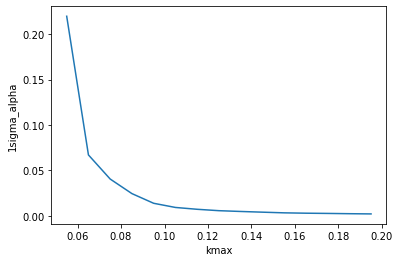

In [205]:
plt.plot(all_kmax,sigmaf)
plt.xlabel("kmax")
plt.ylabel("1sigma_alpha")
#plt.savefig("1sigma_alpha_vs_kmax_covmat.png")

In [276]:
np.savez('bkk_1sigma.npz', kmax=all_kmax, sigmahf=sigmaf,sigma=sigma,hf=hf[10:25])


In [277]:
datab = np.load('bkk_1sigma.npz')

In [279]:
df= pd.DataFrame.from_dict({item: datab[item] for item in datab.files}, orient='index')


In [280]:
df.T

,kmax,sigmahf,sigma,hf
0,0.195,0.002177,0.001083,4.111607
1,0.185,0.002415,0.001420,2.851393
2,0.175,0.002722,0.001833,2.235437
3,0.165,0.002967,0.002162,1.871951
4,0.155,0.003362,0.002625,1.635879
5,0.145,0.004098,0.003379,1.471246
6,0.135,0.004875,0.004190,1.352423
7,0.125,0.005738,0.005103,1.263374
8,0.115,0.007272,0.006643,1.196104
9,0.105,0.009296,0.008684,1.144099
